In [28]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')
# import installed packages
import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.tsa.seasonal import STL
# import functions from custom modules
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from diel_tools import *
from fig_tools import *
from tsd_functions import *

# Generate simulated 10 day dataset from Zinser et al experimental data
1. Combine Hourly Qc data, PAR, gross 14C fixation, carbon loss into one dataset. 
>a) Calculate net carbon fixation from gross fixation and carbon loss
2. Repeat days from original dataset 5x to get 10 day simulated dataset.
3. Randomly remove data of certain percentages.
4. Run iterative interpolation to impute new values. 
5. Compare imputed values against original values to calculate error (RMSE).
6. Block bootstrap to get uncertainites for productivity measurements.

### Calculating hourly Qc from FCM and combining with measurements data
Returns single dataframe with all necessary data for analysis: `pro_data`

In [34]:
# read in flow cytometry data
culture_data=pd.read_csv('data/zinser_figure2a.csv')
psd_data=pd.read_csv('data/zinser_psd.csv')

#### reformat to calculate hourly average Qc ####
# get experimental time from culture dataset
X = list(culture_data['exper time'])
# get size classes from psd data columns
Y = list(psd_data.columns[1:].astype(float))
# get particle size distrubition data from dataframe
Z = psd_data.iloc[:,1:].T.to_numpy()

# make new dataframe with particle size distribution data and reset the index
df = pd.DataFrame(data=Z, columns=X, index=Y).reset_index()
# rename column to size_bin
df.rename(columns={'index':'size_bin'},inplace=True)
# reformat data from wide to long
df_long=pd.melt(df, id_vars=['size_bin'], var_name='hour', value_name='abundance')
# calculate sum of each size bin using size and abundance
df_long['Qc_sum'] = df_long['size_bin'] * df_long['abundance']
# filter out size classes with no abundance
df_long = df_long[df_long.abundance > 0]

# group by cruise and date to get n and summed qc by the hour
df_group = df_long.groupby(['hour']).sum().reset_index()
# get mean Qc per hour and convert Qc from fg -> pg
df_group['Qc_hour'] = (df_group['Qc_sum']/df_group['abundance'])/1000
# subset just the columns we care about
pro_data = df_group[['hour','Qc_hour']]

#### Add in PAR and measurements data ####
# get PAR data
ds = xr.open_dataset('/Users/Kathy/Desktop/UW/seaflow/decomposition_project/data/zinser_processed.nc',
                    decode_times=False)
pro_data['par']=ds.PAR.values
# get c-fixation and loss data
gt = xr.open_dataset('/Users/Kathy/Desktop/UW/seaflow/decomposition_project/data/zinser_ground_truth.nc',
                    decode_times=False)
# get carbon fixation for all rows in pg
pro_data['GPP']=gt.carbonfix.values/1000
# get carbon loss for all rows except last in pg
pro_data.loc[0:23,'carbonloss']=gt.carbonloss.values/1000

### Generate 10 day simulated dataset
Cuts off the last day to repeat to produce continuous transition into next simulated days

In [38]:
# helper function to fill shading for "nights"
def plot_night_day(ax, ylims):
    # fill uin shading
    ax.fill_between(ten_days['hour'], 0, 1, 
                    where=ten_days['par'] == 0,color='gray', alpha=0.3, transform=twinax.get_xaxis_transform())
    # set y limits
    ax.set_ylim(ylims[0],ylims[1])
    # hide y ticks
    ax.tick_params(left=False, labelleft=False, top=False, labeltop=False,
                   right=False, labelright=False, bottom=False, labelbottom=False)

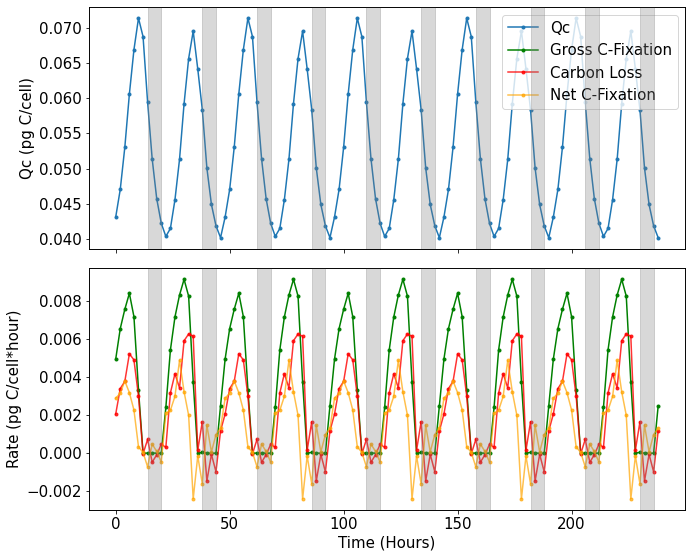

In [42]:
# create 10 day simulated data for Qc data
ten_days=pd.concat([pro_data[:-1]]*5).reset_index().drop(columns=['index'])
# reformat hour column to represent new, simulated time
ten_days['hour']=np.arange(0,len(ten_days)*2,2)

#### Plot to check if simulation successful ####
# create figure
fig,axs=plt.subplots(figsize=(10,8), nrows=2,sharex=True)
# plot hourly Qc
ln0=axs[0].plot(ten_days['hour'],ten_days['Qc_hour'],marker='.', label='Qc')
# set labels and titles
axs[0].set_ylabel('Qc (pg C/cell)')
# set up secondary axis
twinax=axs[0].twinx()
# plot night and day for secondary axis in top subplot
plot_night_day(twinax, (-0.00075,0.01))

# plot Gross PP in bottom subplot
ln1=axs[1].plot(ten_days['hour'],ten_days['GPP'],marker='.', label='Gross C-Fixation', c='g')
# plot C-loss
ln2=axs[1].plot(ten_days['hour'],ten_days['carbonloss'],marker='.', label='Carbon Loss', c='red',alpha=0.8)
# plot net PP
ln3=axs[1].plot(ten_days['hour'],ten_days['GPP']-ten_days['carbonloss'],
            marker='.', label='Net C-Fixation', c='orange',alpha=0.7)

# plot day night
twinax=axs[1].twinx()
# plot night and day for secondary axis in top subplot
plot_night_day(twinax, (-0.00075,0.01))

# create combined legend for all components 
lns=ln0+ln1+ln2+ln3
labs = [l.get_label() for l in lns]
axs[0].legend(lns,labs,loc='upper right')
# axis labels
axs[1].set_xlabel('Time (Hours)')
axs[1].set_ylabel('Rate (pg C/cell*hour)')

plt.rcParams.update({'font.size':15})
plt.tight_layout()

### Randomly remove data 
Try with varying percentages of missing data

In [152]:
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import compress, product
import math
from random import sample

# helper function to iteratively look for missing data (from Züfle et al. 2020 paper)
## edge cases: edges where forward/back pattern is also missing
def iteratively_impute(sub_df, col):
    # set cutoff for max index
    cutoff=np.max(sub_df.index)
    # iteratively impute missing data 
    for index, row in sub_df.iterrows():
        # check if missing
        if math.isnan(row[col]):
            # index 24 hours before
            back_ind=index-24
            # index 24 hours after
            fwd_ind=index+24
            # get current trend
            trend_curr = sub_df.loc[index,'trend']
            # if neither exist, skip row (fill with l-int. later)
            if (back_ind<0)&(fwd_ind>=cutoff):
                continue
            # if 24 hours before doesn't exist or is missing, only use back
            elif (back_ind<0):
                diam_smooth=sub_df.loc[fwd_ind, col]
                trend_factor=sub_df.loc[fwd_ind,'trend']
            # if 24 hours after doesn't exist or is missing, only only use fwd
            elif fwd_ind>=len(sub_df):
                diam_smooth=sub_df.loc[back_ind, col]
                trend_factor=sub_df.loc[back_ind,'trend']
            # if both exist, take the average (ignorning nan)
            else:
                diam_smooth=np.nanmean([sub_df.loc[fwd_ind, col],sub_df.loc[back_ind, col]])
                trend_factor=trend_curr

            diam_pred=(trend_curr/trend_factor)*diam_smooth
            sub_df.loc[index,col]=diam_pred
            # set filled flag
            sub_df.loc[index,'filled']=1
        # not missing
        else:
            # set filled flag if not missing
            sub_df.loc[index,'filled']=1
    return(sub_df)

## helper function to generate missing data from Qc column
# inputs: df=dataframe with "Qc_hourly" column, p = float that specifies % of data to remove
# returns: missing_data=data_frame with new column with data removed
def generate_missing_data(df, p):
    # make copy of dataframe 
    missing_data=df.copy()
    # grab hourly Qc only
    qc_only=missing_data[['Qc_hour']]
    # calculate number of nans to add to data
    n = int(qc_only.shape[0]*p)
    # randomly sample to get indices to remove data
    ids = sample(list(product(range(qc_only.shape[0]), range(qc_only.shape[1]))), n)
    # grab indices of missing data
    idx, idy = list(zip(*ids))
    # reshape data to numpy
    data=qc_only.to_numpy().astype(float)
    # update numpy view with np.nan
    data[idx,idy]=np.nan
    # store column with missing data in dataframe
    missing_data['with_missing']=data
    # add population column
    missing_data['pop']='prochloro'
    return(missing_data)

## helper function to run imputation function and fill in data
# input: missing_df=dataframe with 'with_missing' column with data removed
# returns: final_impute=dataframe with imputed data in 'with_missing'
def run_imputation(missing_df):
    # create subsetted df excluding nan values 
    missing_cont=missing_df.loc[missing_df['with_missing'].notna()]

    # run seasonal decomposition on raw data and drop nan values for now
    train=missing_cont['with_missing']
    decompose=seasonal_decompose(train, model='multiplicative', period=24, extrapolate_trend='freq')
    #get trend and seasonal components
    missing_cont.loc[train.index, 'trend']=decompose.trend
    missing_cont.loc[train.index, 'seasonal']=decompose.seasonal

    # set index as time for interpolation
    missing_cont.set_index('hour',inplace=True)
    # grab first and last hours of complete dataframe
    hour_range=missing_25.iloc[[0,-1]]['hour'].values
    # create resamppled list 
    resampled=np.arange(hour_range[0],hour_range[1]+1, 2)
    # resample interpolated list
    missing_resamp = missing_cont.reindex(missing_cont.index.union(
        resampled)).interpolate('values',limit_direction='both').loc[resampled]
    # add missing diam_med data back to interpolated data
    missing_resamp['with_missing']=missing_cont['with_missing']

    # add flag to check if filled
    missing_resamp['filled']=0
    # iteratively impute
    pre_impute =iteratively_impute(missing_resamp, 'with_missing')
    # fill additional gaps with linear interpolation
    final_impute = pre_impute.reindex(pre_impute.index.union(
        resampled)).interpolate(limit_direction='both',axis=0).loc[resampled].reset_index()
    # replace Qc_hour with its original values
    final_impute['Qc_hour']=missing_25['Qc_hour']
    return(final_impute)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


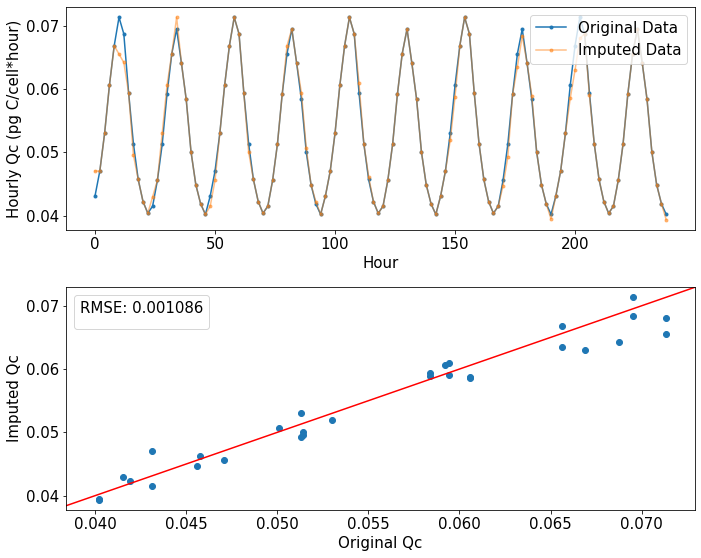

In [157]:
from sklearn.metrics import mean_squared_error
# generate missing data
# missing_25=generate_missing_data(ten_days, 0.25)
# calculate imputed values
impute_df=run_imputation(missing_25)

#### plot results ####
# plot missing filled data with truth data
fig,axs = plt.subplots(figsize=(10,8), nrows=2)
# plot missing data first
axs[0].plot(impute_df['hour'], impute_df['Qc_hour'], marker='.', label='Original Data')
# plot filled in data
axs[0].plot(impute_df['hour'], impute_df['with_missing'], marker='.', label='Imputed Data', alpha=0.5)

# calculate RMSE
rmse=mean_squared_error(impute_df.Qc_hour.values, impute_df.with_missing.values, squared=False)

# add legend and labels
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Hourly Qc (pg C/cell*hour)')

# create second subplot of comparision with missing data
filled_df=impute_df.loc[impute_df['pop'].isnull()]
# plot comparision of both
axs[1].plot(filled_df['Qc_hour'], filled_df['with_missing'], marker='o',linestyle='')
# add 1:1 line
axs[1].axline((0.04, 0.04), (0.07, 0.07),c='red')
axs[1].set_xlabel('Original Qc')
axs[1].set_ylabel('Imputed Qc')
axs[1].legend(title=f'RMSE: {np.round(rmse,6)}')

plt.tight_layout()

### Calculate growth rates and productivity on imputed datasets
Compare against measurements to get error

In [161]:
# function to run STL model to first get diel component
## input: df=dataframe with imputed data, col=string representation of column with imputed data
## output: pro_res = dataframe with cleaned tsd components for pro, syn_res=same but with syn
def run_STL(df, col, robust=True):
    # get data to run in model
    train=df[col]
    # Run multiplicative STL model
    period=24
    stl_model = STL(np.log(train), period=period, robust=robust, seasonal=15)
    # fit to data
    stl_fit = stl_model.fit()
    
    # add components to datasets
    df['trend']=np.exp(stl_fit.trend.values.reshape(-1,1))
    df['diel']=np.exp(stl_fit.seasonal.values.reshape(-1,1))
    # return both components
    return df

In [162]:
run_STL(impute_df, 'with_missing')

,hour,Qc_hour,par,GPP,carbonloss,with_missing,pop,trend,seasonal,filled,diel
0,0,0.043129,199.521423,6.556686e-03,0.003401,0.047061,NaN,0.052425,0.956186,1,0.822677
1,2,0.047061,199.521423,6.556686e-03,0.003401,0.047061,prochloro,0.052424,0.956186,1,0.897714
2,4,0.053032,226.445848,7.574984e-03,0.003777,0.053032,prochloro,0.052422,0.991824,1,1.011629
3,6,0.060581,226.069041,8.414698e-03,0.005229,0.060581,prochloro,0.052421,1.093728,1,1.119176
4,8,0.066867,224.277784,7.187658e-03,0.004913,0.066867,prochloro,0.052420,1.024773,1,1.275589
...,...,...,...,...,...,...,...,...,...,...,...
115,230,0.058370,0.000000,4.005195e-05,0.001653,0.058370,prochloro,0.052295,1.035945,1,1.116157
116,232,0.050111,0.000000,-2.800356e-07,-0.001469,0.050111,prochloro,0.052294,0.958121,1,0.958258
117,234,0.044922,0.000000,7.095304e-07,-0.000064,0.044922,prochloro,0.052293,0.909390,1,0.859042
118,236,0.041898,0.000000,-1.809134e-08,-0.000978,0.041898,prochloro,0.052292,0.895055,1,0.801229
